In [2]:
!pip install -q -U transformers peft accelerate

In [3]:
!pip install -q evaluate rouge_score sacrebleu scikit-learn matplotlib seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 9.1 MB/s eta 0:00:00


In [4]:
import random
import numpy as np
import torch
from transformers import set_seed
import os
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    set_seed(seed) # Transformers specific seed

# Call this first!
seed_everything(42)

2026-01-16 14:09:01.145767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768572541.332607      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768572541.384927      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768572541.827181      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768572541.827227      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768572541.827230      55 computation_placer.cc:177] computation placer alr

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Blip2Processor, 
    Blip2ForConditionalGeneration, 
    TrainingArguments, 
    Trainer
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [6]:
# ========================================================
# 1. SETUP PATHS
# ========================================================
# Update this if your folder name is different in Kaggle
DATASET_DIR = '/kaggle/input/vqarad'  
IMG_DIR = os.path.join(DATASET_DIR, 'VQA_RAD Image Folder')
TRAIN_CSV = os.path.join(DATASET_DIR, 'vqa_rad_train.csv')
VAL_CSV = os.path.join(DATASET_DIR, 'vqa_rad_valid.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'vqa_rad_test.csv')

BASE_MODEL_ID = "Salesforce/blip2-opt-2.7b"
OUTPUT_DIR = "./vqarad-p100-final"

# Load Metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Blip2Processor, 
    Blip2ForConditionalGeneration, 
    TrainingArguments, 
    Trainer
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ========================================================
# 1. SETUP PATHS
# ========================================================
# Update this if your folder name is different in Kaggle
DATASET_DIR = '/kaggle/input/vqarad'  
IMG_DIR = os.path.join(DATASET_DIR, 'VQA_RAD Image Folder')
TRAIN_CSV = os.path.join(DATASET_DIR, 'vqa_rad_train.csv')
VAL_CSV = os.path.join(DATASET_DIR, 'vqa_rad_valid.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'vqa_rad_test.csv')

BASE_MODEL_ID = "Salesforce/blip2-opt-2.7b"
OUTPUT_DIR = "./vqarad-p100-final"

# Load Metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# ========================================================
# 2. DATASET CLASS (Updated for your CSV structure)
# ========================================================
class VQARADDataset(Dataset):
    def __init__(self, csv_file, img_dir, processor, mode='train'):
        self.img_dir = img_dir
        self.processor = processor
        self.mode = mode
        self.data = pd.read_csv(csv_file)
        
        # Ensure correct types
        self.data['question'] = self.data['question'].astype(str)
        self.data['answer'] = self.data['answer'].astype(str)
        # Fill missing answer_types with 'OPEN' just in case, though your CSV looks good
        if 'answer_type' in self.data.columns:
            self.data['answer_type'] = self.data['answer_type'].astype(str).str.upper()
        else:
            self.data['answer_type'] = 'OPEN'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = row['img_id']      # e.g., "synpic54610.jpg"
        question = row['question']
        answer = row['answer']
        ans_type = row['answer_type'] # e.g., "CLOSED" or "OPEN"
        
        # --- 1. Load Image ---
        # Your CSV already has the extension, so we use it directly.
        img_path = os.path.join(self.img_dir, img_id)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Fallback if path is wrong or file missing
            image = Image.new('RGB', (224, 224), color='black')

        # --- 2. Prompt Logic ---
        # If it's a CLOSED question, we explicitly ask for Yes/No.
        if ans_type == 'CLOSED':
            prompt = f"Question: {question} Answer yes or no. Answer:"
        else:
            prompt = f"Question: {question} Answer:"

        # --- 3. Return Logic ---
        if self.mode == 'train':
            # For training, we append the actual answer
            full_text = f"{prompt} {answer}"
            
            inputs = self.processor(
                images=image, text=full_text, return_tensors="pt", 
                padding="max_length", max_length=64, truncation=True
            )
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs['labels'] = inputs['input_ids'].clone()
            return inputs
        else:
            # For Test/Val, we just return the prompt and metadata
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            
            inputs['ground_truth'] = answer
            inputs['answer_type'] = ans_type # Pass this for the metrics!
            return inputs

# ========================================================
# 3. LOAD MODEL (P100 FP16 Configuration)
# ========================================================
print("--- Loading Model ---")

processor = Blip2Processor.from_pretrained(BASE_MODEL_ID)

model = Blip2ForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID, 
    torch_dtype=torch.float16, # FP16 for P100
    device_map="auto"
)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05, bias="none", 
    task_type="CAUSAL_LM", target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# ========================================================
# 4. TRAINING
# ========================================================

# Note: Ensure your Train/Val CSVs have the same structure (answer_type column)
# If not, the dataset class might need a tiny tweak to handle missing cols in train.
train_dataset = VQARADDataset(TRAIN_CSV, IMG_DIR, processor, mode='train')
eval_dataset = VQARADDataset(VAL_CSV, IMG_DIR, processor, mode='train')

def collate_fn(batch):
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    learning_rate=2e-4,
    fp16=True,
    eval_strategy="epoch",      # Updated from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    report_to="none",
    logging_steps=5
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn
)

print("\n--- Starting Training ---")
trainer.train()
model.save_pretrained(OUTPUT_DIR)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


--- Loading Model ---


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2db6cc03-12a2-4342-834e-67a55f1aaf37)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip2-opt-2.7b/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1f15caea-72cc-4dc9-b47f-17f23e1b3b3f)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip2-opt-2.7b/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 74fbe1d4-23da-4037-a6c5-d65d4b23a694)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip2-opt-2.7b/resolve/main/vocab.json
Retrying in 1s [Retry 1/5].


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7d0e297e-f180-4b1d-855b-6f3fabe53f18)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip2-opt-2.7b/resolve/59a1ef6c1e5117b3f65523d1c6066825bcf315e3/model-00001-of-00002.safetensors
Retrying in 1s [Retry 1/5].


model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398

--- Starting Training ---


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,1.041800,0.441678
2,0.804600,0.411876
3,0.799200,0.406364
4,0.771300,0.398927
5,0.674100,0.398170


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [8]:
!pip install -q scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



   Running COMPREHENSIVE Evaluation on /kaggle/input/vqarad/vqa_rad_test.csv


100%|██████████| 225/225 [01:55<00:00,  1.95it/s]



----------------------------------------
RESULTS: CLOSED QUESTIONS (144 samples)
----------------------------------------
  Accuracy:                59.72%
  Precision (Weighted):    0.6137
  Recall (Weighted):       0.5972
  F1-Score (Weighted):     0.6024
  ROUGE-L:                 0.6065
  BLEU-2:                  0.3877

----------------------------------------
RESULTS: OPEN QUESTIONS (81 samples)
----------------------------------------
  Accuracy:                19.75%
  Precision (Weighted):    0.1556
  Recall (Weighted):       0.1975
  F1-Score (Weighted):     0.1696
  ROUGE-L:                 0.2852
  BLEU-2:                  0.0686

OVERALL DATASET RESULTS (225 samples)
  OVERALL Accuracy:        45.33%
  OVERALL Precision:       0.4560
  OVERALL Recall:          0.4533
  OVERALL F1 (Weighted):   0.4468
  OVERALL ROUGE-L:         0.4914

>>> CONFUSION MATRIX (Closed-Ended: Yes vs No)


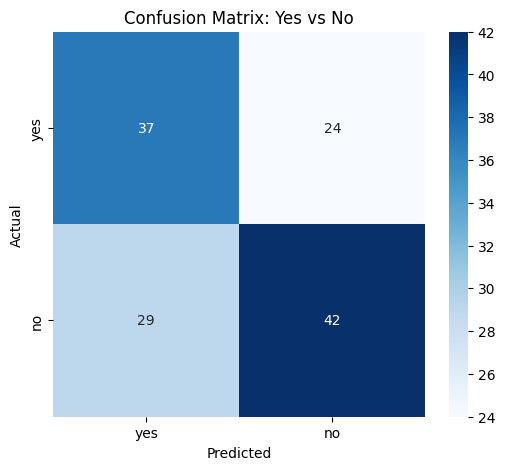

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

# Define text cleaner
def normalize_text(text):
    return text.lower().strip().replace('.', '')

def run_full_metrics_evaluation(csv_path):
    print(f"\n=======================================================")
    print(f"   Running COMPREHENSIVE Evaluation on {csv_path}")
    print(f"=======================================================")
    
    # 1. Setup Loader
    ds = VQARADDataset(csv_path, IMG_DIR, processor, mode='test')
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    
    model.eval()
    
    # 2. Storage
    # Separate storage for detailed analysis
    data = {
        "CLOSED": {"preds": [], "refs": []},
        "OPEN":   {"preds": [], "refs": []}
    }
    
    # Global storage for Overall Metrics
    all_preds = []
    all_refs = []
    
    # 3. Inference Loop
    for batch in tqdm(loader):
        input_ids = batch.pop("input_ids").to("cuda")
        pixel_values = batch.pop("pixel_values").to("cuda")
        
        ground_truth = normalize_text(batch['ground_truth'][0])
        ans_type = batch['answer_type'][0]
        
        with torch.no_grad():
            output_ids = model.generate(
                input_ids=input_ids,
                pixel_values=pixel_values,
                max_new_tokens=10, 
                do_sample=False
            )
        
        # Decode
        pred = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
        pred = normalize_text(pred)
        
        # --- CLEANING LOGIC ---
        if "answer yes or no" in pred:
            pred = pred.replace("answer yes or no", "").strip()
        if "question" in pred:
            pred = pred.split("answer:")[-1].strip()
            
        # Store for Category Analysis
        if ans_type == 'CLOSED':
            data["CLOSED"]["preds"].append(pred)
            data["CLOSED"]["refs"].append(ground_truth)
        else:
            data["OPEN"]["preds"].append(pred)
            data["OPEN"]["refs"].append(ground_truth)
            
        # Store for Overall Analysis
        all_preds.append(pred)
        all_refs.append(ground_truth)

    # 4. Calculate & Print Metrics for each Category
    for category in ["CLOSED", "OPEN"]:
        preds = data[category]["preds"]
        refs = data[category]["refs"]
        
        if len(preds) == 0: continue
        
        print(f"\n" + "-"*40)
        print(f"RESULTS: {category} QUESTIONS ({len(preds)} samples)")
        print("-"*40)
        
        # Metrics
        acc = accuracy_score(refs, preds)
        
        # --- MODIFIED: Unpack Precision and Recall here ---
        precision, recall, f1, _ = precision_recall_fscore_support(
            refs, preds, average='weighted', zero_division=0
        )
        
        b2 = bleu_metric.compute(predictions=preds, references=[[r] for r in refs], max_order=2)
        rouge = rouge_metric.compute(predictions=preds, references=refs)

        # Print
        print(f"  Accuracy:                {acc*100:.2f}%")
        print(f"  Precision (Weighted):    {precision:.4f}") # Added
        print(f"  Recall (Weighted):       {recall:.4f}")    # Added
        print(f"  F1-Score (Weighted):     {f1:.4f}")
        print(f"  ROUGE-L:                 {rouge['rougeL']:.4f}")
        print(f"  BLEU-2:                  {b2['bleu']:.4f}")

    # 5. --- NEW SECTION: OVERALL METRICS ---
    print(f"\n" + "="*40)
    print(f"OVERALL DATASET RESULTS ({len(all_preds)} samples)")
    print("="*40)
    
    # Calculate Overall Accuracy
    overall_acc = accuracy_score(all_refs, all_preds)
    
    # --- MODIFIED: Calculate Overall Precision and Recall ---
    overall_prec, overall_rec, overall_f1, _ = precision_recall_fscore_support(
        all_refs, all_preds, average='weighted', zero_division=0
    )
    
    # Calculate Overall ROUGE-L
    overall_rouge = rouge_metric.compute(predictions=all_preds, references=all_refs)
    
    print(f"  OVERALL Accuracy:        {overall_acc*100:.2f}%")
    print(f"  OVERALL Precision:       {overall_prec:.4f}") # Added
    print(f"  OVERALL Recall:          {overall_rec:.4f}")    # Added
    print(f"  OVERALL F1 (Weighted):   {overall_f1:.4f}")
    print(f"  OVERALL ROUGE-L:         {overall_rouge['rougeL']:.4f}")

    # 6. Confusion Matrix (Closed-Ended Only)
    c_preds = data["CLOSED"]["preds"]
    c_refs = data["CLOSED"]["refs"]
    
    labels = ['yes', 'no']
    
    # Filter valid indices for plotting
    valid_indices = [i for i, r in enumerate(c_refs) if r in labels]
    filtered_refs = [c_refs[i] for i in valid_indices]
    filtered_preds = [c_preds[i] for i in valid_indices]
    
    final_refs = []
    final_preds = []
    for r, p in zip(filtered_refs, filtered_preds):
        if p in labels:
            final_refs.append(r)
            final_preds.append(p)
            
    if len(final_refs) > 0:
        print("\n>>> CONFUSION MATRIX (Closed-Ended: Yes vs No)")
        cm = confusion_matrix(final_refs, final_preds, labels=labels)
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix: Yes vs No')
        plt.show()

# Run the full evaluation
run_full_metrics_evaluation(TEST_CSV)

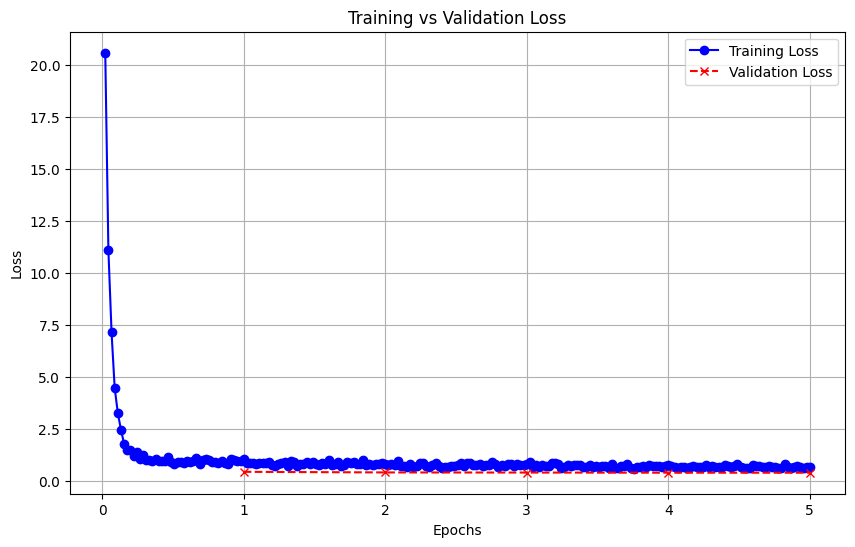

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(trainer):
    # 1. Extract logs
    log_history = trainer.state.log_history
    
    # Lists to store data
    train_epochs = []
    train_losses = []
    val_epochs = []
    val_losses = []

    # 2. Parse logs
    for entry in log_history:
        # Extract Training Loss
        if 'loss' in entry:
            train_epochs.append(entry['epoch'])
            train_losses.append(entry['loss'])
        
        # Extract Validation Loss
        if 'eval_loss' in entry:
            val_epochs.append(entry['epoch'])
            val_losses.append(entry['eval_loss'])

    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot Training Loss
    if len(train_losses) > 0:
        plt.plot(train_epochs, train_losses, label='Training Loss', marker='o', color='blue')
    
    # Plot Validation Loss
    if len(val_losses) > 0:
        plt.plot(val_epochs, val_losses, label='Validation Loss', marker='x', color='red', linestyle='--')
    
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- CALL THE FUNCTION ---
plot_training_history(trainer)